<h1>
<center>CFRM 421/521, Spring 2023</center>
</h1>

<h1>
<center>Tong Wu twu6</center>
</h1>

<h1>
<center>Homework 2</center>
</h1>

* **Due: Tuesday, April 29, 2024, 11:59 PM**


* Total marks: 45


* Late submissions are allowed, but a 20% penalty per day applies. Your last submission is considered for calculating the penalty.


*  Use this Jupyter notebook as a template for your solutions. **Your solution must be submitted as both one Jupyter notebook and one PDF file on Gradescope.** There will be two modules on Gradescope, one for each file type. The notebook must be already run, that is, make sure that you have run all the code, save the notebook, and then when you reopen the notebook, checked that all output appears as expected. You are allowed to use code from the textbook, textbook website, or lecture notes.

# 1. Random forest for time series data [14 marks]

In this question you will work with the NYSE dataset. Only 3 time series in this dataset will be use: `DJ_return` ($a_t$), `log_volatility` ($b_t$), and `log_volume` ($c_t$). Download the data as a csv file from [Canvas](https://canvas.uw.edu/files/105167110/download?download_frd=1). The data was originally obtained from the R library ISLR2, and you can read the documentation for the dataset [here](https://cran.rstudio.com/web/packages/ISLR2/ISLR2.pdf), which explains the meaning of the variables.

You want to predict the 1-step ahead value of `log_volume` $c_{t+1}$ using the previous values of this variable and the other two variables (`DJ_return` and `log_volatility`) up to 5 lags. So the features are $c_{t},\dots,c_{t-4},b_{t},\dots,b_{t-4},a_{t},\dots,a_{t-4}$.

If the data is stored in a file named `NYSE.csv` in your working directory, then loading the data can be done using the code below.

In [1]:
import os
import pandas as pd
data = pd.read_csv("/Users/lydia22/Desktop/Junior/CFRM421 HW2/NYSE.csv")

## (a) [3 marks]

Create the feature matrix `X` and the target variable `y`. Print at least the first 2 rows of `X` and `y` (it is acceptable that not every element of the rows are printed).

**Solution:**

In [2]:
print(data.head())

         date day_of_week  DJ_return  log_volume  log_volatility  train
0  1962-12-03         mon  -0.004461    0.032573      -13.127403   True
1  1962-12-04        tues   0.007813    0.346202      -11.749305   True
2  1962-12-05         wed   0.003845    0.525306      -11.665609   True
3  1962-12-06        thur  -0.003462    0.210182      -11.626772   True
4  1962-12-07         fri   0.000568    0.044187      -11.728130   True


In [3]:
# define the variables I will create lags for 
vars_lag = ['log_volume', 'log_volatility', 'DJ_return']
# build a new column, generate based on variable and lag of the loop
diction = {f'{var}_lag{lag}': data[var].shift(lag)
        for var in vars_lag
        for lag in range(5)}
# build a dictionary with expression, and loop 
X = pd.DataFrame(diction)
# select the log volume and move up by one row. 
y = data['log_volume'].shift(-1) #y[t] = c_{t+1}
y = y.loc[X.index]
# Print first 2 rows
print("First 2 rows of X:")
print(X.head(2))
print("First 2 rows of y:")
print(y.head(2))

First 2 rows of X:
   log_volume_lag0  log_volume_lag1  log_volume_lag2  log_volume_lag3  \
0         0.032573              NaN              NaN              NaN   
1         0.346202         0.032573              NaN              NaN   

   log_volume_lag4  log_volatility_lag0  log_volatility_lag1  \
0              NaN           -13.127403                  NaN   
1              NaN           -11.749305           -13.127403   

   log_volatility_lag2  log_volatility_lag3  log_volatility_lag4  \
0                  NaN                  NaN                  NaN   
1                  NaN                  NaN                  NaN   

   DJ_return_lag0  DJ_return_lag1  DJ_return_lag2  DJ_return_lag3  \
0       -0.004461             NaN             NaN             NaN   
1        0.007813       -0.004461             NaN             NaN   

   DJ_return_lag4  
0             NaN  
1             NaN  
First 2 rows of y:
0    0.346202
1    0.525306
Name: log_volume, dtype: float64


## (b)  [5 marks]

Consider fitting a random forest to predict the 1-step ahead value of `log_volume`. The random forest must include the argument `random_state=42`, and it is useful to also include `n_jobs=-1` (you can use `n_job=-1` throughout this homework wherever it is avaliable). Use 3-fold time series CV split, with the test set split 50% into a validation set and 50% into the actual test set, to tune the hyperparameters `n_estimators` taking the values  200, 400, 600, and the cost-complexity pruning parameter $\alpha$ taking the values $10^{-k}$, $k=1,3,5,7$. When tuning hyperparameters on the validation sets, fit the model only on a random 10% sample of the instances of the training set on the same CV fold to reduce computational time (that is, use the same reduced training set for all the hyperparameters, but a different one for each CV fold). Note this will still preserve the correct time ordering, and the reduce training set should not be used when fitting and evaluating the best model on the test set. The performance measure is RMSE. Report the best hyperparameters.

**Solution:**

In [4]:
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [6]:
n_estimators_grid = [200, 400, 600]
ccp_alpha_grid = [10**-k for k in [1, 3, 5, 7]]
# do split for time series
tscv = TimeSeriesSplit(n_splits=3)
result = []
fold = 0
# split the X data, train_val_idx and test_idx come from the split
for train_val_idx, test_idx in tscv.split(X): 
    X_train_val, X_test = X.iloc[train_val_idx], X.iloc[test_idx] # split x train and x test
    y_train_val, y_test = y.iloc[train_val_idx], y.iloc[test_idx] # split y train and y test
    # split to 50% validation set and 50% to the actual test set
    split_point = int(len(X_test) / 2) # make sure it is a interger
    X_val, X_final_test = X_test[:split_point], X_test[split_point:]
    y_val, y_final_test = y_test[:split_point], y_test[split_point:]
    small_size = int(0.1 * len(X_train_val)) # smaller size 
    train_small_idx = np.random.RandomState(42).choice(X_train_val.index, size=small_size)
    X_train_small = X.loc[train_small_idx]
    y_train_small = y.loc[train_small_idx]
    
    fold += 1 
    for estimator in n_estimators_grid:
        for alpha in ccp_alpha_grid:
            rf = RandomForestRegressor(n_estimators=estimator, 
                                       ccp_alpha=alpha, 
                                       random_state=42)
            rf.fit(X_train_small, y_train_small)
            # fit on the 10% training set 
            y_pred_val = rf.predict(X_val)
            # predict on the validation set 
            rmse_val = mean_squared_error(y_val, y_pred_val)
            # compute rmse on validation 
            result.append({'fold': fold,'n_estimators': estimator,'ccp_alpha': alpha,
                           'rmse_val': rmse_val})
            
results_df = pd.DataFrame(result)

# Find the best hyperparameters by lowest average RMSE across folds
avg_rmse = results_df.groupby(['n_estimators', 'ccp_alpha'])['rmse_val'].mean()

best_index = avg_rmse.idxmin()
best_rmse = avg_rmse.min()
best_n_estimators, best_ccp_alpha = best_index

print("\nBest Hyperparameters:")
print(f"n_estimators = {best_n_estimators}, ccp_alpha = {best_ccp_alpha:.1e}")
print(f"Validation RMSE: {best_rmse:.4f}")


Best Hyperparameters:
n_estimators = 200, ccp_alpha = 1.0e-05
Validation RMSE: 0.0276


## (c)  [2 marks]

Using the same time series split as in (b), compute the RMSE of the best fitting model on the test set, and include a plot of the true values and predicted values on the test set of the last fold (the fold closest to the current time) of the CV.

**Solution**:

In [7]:
import matplotlib.pyplot as plt

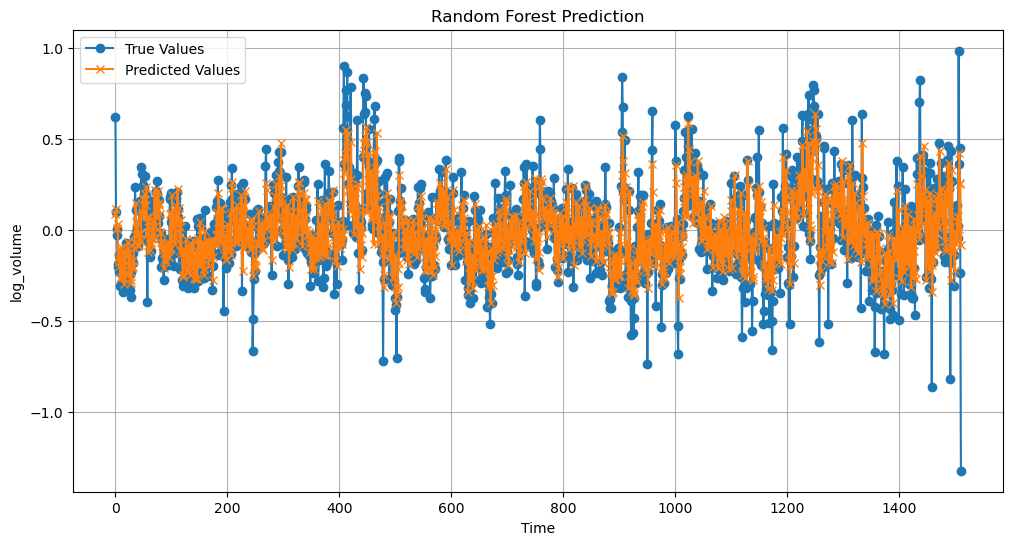

In [8]:
X_clean = X.dropna()
time_serie_split = list(tscv.split(X_clean))
last_train_val_idx, last_test_idx = time_serie_split[-1]

X_train = X.iloc[last_train_val_idx]
y_train = y.iloc[last_train_val_idx]
X_test = X.iloc[last_test_idx]
y_test = y.iloc[last_test_idx]

best_model = RandomForestRegressor(
    n_estimators=int(best_n_estimators),
    ccp_alpha=float(best_ccp_alpha),
    random_state=42)

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
rmse_test = mean_squared_error(y_test, y_pred)
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='True Values', marker='o')
plt.plot(y_pred, label='Predicted Values', marker='x')
plt.title('Random Forest Prediction')
plt.xlabel('Time')
plt.ylabel('log_volume')
plt.legend()
plt.grid(True)
plt.show()

## (d) [2 marks]

It is often useful to check that your model is not worse than a very simple method of prediction. On the test set, compute the RMSE of a model that simply predicts the 1-step ahead value of `log_volume` $c_{t+1}$ as the current value $c_t$, and compare this to the best fitting random forest model.

**Solution**:

In [9]:
#predict c_{t+1} = c_t (which is today's value)
# use the test data, so the model will not predict precisely 
y_pred0 = X_test['log_volume_lag0']
#predict t+1 log volume to be todays's which is t 

rmse0 = mean_squared_error(y_test, y_pred0)

if rmse_test < rmse0:
    print("Random Forest model is better than the simple prediction.")
else:
    print("Random Forest model is worse than to the simple prediction.")

Random Forest model is better than the simple prediction.


## (e) [2 marks]

Compute the feature importances of the best fitting model. Which feature is the most important and what is its feature importance value?

**Solution:**

In [10]:
importances = best_model.feature_importances_
features = X.columns
important_df = pd.DataFrame({
    'feature': features,
    'importance': importances})
max_idx = important_df['importance'].idxmax()
most_important = important_df.loc[max_idx]

print("Most important feature:")
print(f"Feature: {most_important['feature']}")
print(f"Importance: {most_important['importance']:.6f}")

Most important feature:
Feature: log_volume_lag0
Importance: 0.567857


# 2. SVM classification and regression [11 marks]

For all SVM models in this question use a standard scaler.

## (a) [2 marks]

In this question, a SVM is used for classification for the MNIST dataset. The following code loads the MNIST dataset, creates the test set, and to reduce training time, takes a random sample of 2000 points from the full training set to use as your actual training set stored in `X` and `y`. Do not shuffle the data.

Hint: Reading the solution to Question 9 in the Chapter 5 [Jupyter notebook](https://github.com/ageron/handson-ml2/blob/master/05_support_vector_machines.ipynb) (2nd edition) on the textbook website may help with this question.

In [11]:
import numpy as np
import matplotlib as mlp
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False, cache=True, parser='auto')
X_train = mnist["data"][:60000]
X_test  = mnist["data"][60000:]
y_train = mnist["target"][:60000]
y_test  = mnist["target"][60000:]

In [12]:
from sklearn.model_selection import StratifiedShuffleSplit

N = 2000
split_obj = StratifiedShuffleSplit(n_splits=1,
                               test_size=N/60000, random_state=42)
for other_idx, subsample_idx in split_obj.split(X_train, y_train):
    X = X_train[subsample_idx]
    y = y_train[subsample_idx]

**Task:** Consider fitting the linear SVM classifier (`LinearSVC`) with `max_iter=50000`. For this model, optimize the hyperparameter $C$ using 3-fold CV over the values $10^{-k}$, $k=0,1,\dots,9$, where the performance measure is accuracy. What is the best $C$ and what is the accuracy in this case?

**Solution:**

In [13]:
# tune hyperparameter c using 3 fold cross-validation
# report the best c and the accuracy 
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

In [14]:
C_values = [10**-k for k in range(10)] #define c 
best_score = 0
best_C = 0
for C in C_values:
    svm_clf = LinearSVC(C=C, max_iter=50000, random_state=42)
    scores = cross_val_score(svm_clf, X, y, cv=3, scoring='accuracy')
    mean_score = scores.mean()
    if mean_score > best_score:
        best_score = mean_score
        best_C = C
print("\nBest C:", best_C)
print("Best Accuracy:", best_score)


Best C: 1e-07
Best Accuracy: 0.8624974299636969


## (b) [2 marks]

**Task:** Now consider fitting a SVM with a Gaussian RBF kernel and `max_iter=50000`. For this model, optimize the hyperparameters $C$ over the distrbution `uniform(1,10)` and $\gamma$ over the distribution `loguniform(0.0001, 0.1)` from `scipy.stats.loguniform` with 10 random samples. The `loguniform(a,b)` function takes a random sample from the probability distribution with pdf $f(x)\propto 1/x, x\in[a,b]$. Again, use 3-fold CV and the performance measure is accuracy. What are the best hyperparameters and what is the accuracy in this case?

**Solution:**

In [15]:
from scipy.stats import uniform, loguniform
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV

In [16]:
parameter = {
    'C': uniform(1, 10),
    'gamma': loguniform(0.0001, 0.1)
}
svm_new = SVC(kernel='rbf', max_iter=50000, random_state=42)

search = RandomizedSearchCV(svm_new,
    param_distributions=parameter, n_iter=10, cv=3)

search.fit(X, y)

print("Best params:", search.best_params_)
print("Best CV accuracy: {:.4f}".format(search.best_score_))

Best params: {'C': 6.307943273842448, 'gamma': 0.0005298246366768889}
Best CV accuracy: 0.1125


## (c) [2 mark]

**Task:** Choose the best model in (a) and (b). Then for this model, evaluate the accuracy on the test set, which is stored in `X_test` and `y_test`.

In [17]:
from sklearn.metrics import accuracy_score

In [18]:
#rebuild the model 
best_linear_svc = LinearSVC(C=best_C, max_iter=50000, random_state=42)
best_linear_svc.fit(X, y)

y_pred_test = best_linear_svc.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)

In [19]:
print(f"Test accuracy: {test_accuracy:.4f}")

Test accuracy: 0.8874


**Solution:**

## (d) [3 marks]

Consider the original source of the California housing data (which is different from the modified dataset used in Homework 1) in Scikit-Learn. The data is obtained and split using the code below. The training set is stored in `X_train` and `y_train`. Do not shuffle the data.

Hint: Reading the solution to Question 11 in the Chapter 5 [Jupyter notebook](https://github.com/ageron/handson-ml3/blob/main/05_support_vector_machines.ipynb) (3rd edition) on the textbook website may help with this question.

In [20]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR

housing = fetch_california_housing()
X = housing.data
y = housing.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Task:** Consider SVM regression with a Gaussian RBF kernel and a sigmoid kernel with `max_iter=50000`. For both models, use randomized search to choose good hyperparameter values for `C` and `gamma`, and set the arguement `random_state=42`. For both models, optimize the hyperparameters $C$ over the distrbution `uniform(1,20)` and $\gamma$ over the distribution `loguniform(0.0001, 0.1)` with 20 random samples. To save training time, use only the first 2000 instances of `X_train` and `y_train` (which have been randomly shuffled already) for the search. Again, use 3-fold CV and the performance measure is MSE. What are the best hyperparameters and what is the MSE in this case?

**Solution:**

In [21]:
X_sample = X_train[:2000]
y_sample = y_train[:2000]

In [22]:
parameter_house = {
    'C': uniform(1, 19),  
    'gamma': loguniform(0.0001, 0.1)}

svm_house = SVR(kernel='rbf', max_iter=50000)
# initialize the svm model 
search_house = RandomizedSearchCV(svm_house,
    param_distributions=parameter_house, n_iter=20, cv=3,
                        scoring='neg_mean_squared_error',random_state=42)
#set up the hyperparameter search 
search_house.fit(X_sample, y_sample)
best_hyperparameter = search_house.best_params_
best_mse = -search_house.best_score_ 

In [23]:
print(" Best params:", best_hyperparameter)
print(" Best MSE:   ", best_mse)

 Best params: {'C': 16.816410175208013, 'gamma': 0.00043352817949515634}
 Best MSE:    0.8886917326023677


In [24]:
svm_house2 = SVR(kernel='sigmoid', max_iter=50000)
# initialize the svm model 
search_house2 = RandomizedSearchCV(svm_house2,
    param_distributions=parameter_house, n_iter=20, cv=3,
                        scoring='neg_mean_squared_error',random_state=42)
#set up the hyperparameter search 
search_house2.fit(X_sample, y_sample)
best_hyperparameter2 = search_house2.best_params_
best_mse2 = -search_house2.best_score_ 
print(" Best parameter:", best_hyperparameter2)
print(" Best MSE:   ", best_mse2)

 Best parameter: {'C': 9.206955354200199, 'gamma': 0.0007476312062252299}
 Best MSE:    1.3765452815651011


## (e) [2 marks]

**Task:** Choose the best model in (d). But now refit it on the full training set (not just the first 2000 instances). Then for this model, evaluate the RMSE on the test set, which is stored in `X_test` and `y_test`.

**Solution:**

In [25]:
best_C = best_hyperparameter['C']
best_gamma = best_hyperparameter['gamma']

In [26]:
svm_model = SVR(kernel='rbf', C=best_C, gamma=best_gamma, max_iter=50000)
svm_model.fit(X_train, y_train)

y_pred_svm = svm_model.predict(X_test)

mse_test = mean_squared_error(y_test, y_pred_svm)

rmse_test = np.sqrt(mse_test)


/Users/lydia22/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [27]:
print (rmse_test)

0.7173439190648621


# 3. Voting classifiers [11 marks]
## (a)  [4 marks]

Consider the MNIST dataset. To save computational time, after spliting into a training, validation and test set, we keep only the first 5000 instances of the training set, and only the first 1000 instances of the validation and test set, as given by the following code.

In [28]:
N = 50_000
M = 60_000
X_train = mnist["data"][:N][:5000]
y_train = mnist["target"][:N][:5000]
X_valid  = mnist["data"][N:M][:1000]
y_valid = mnist["target"][N:M][:1000]
X_test  = mnist["data"][M:][:1000]
y_test = mnist["target"][M:][:1000]

Do not shuffle the data and do not use a standard scaler. Train the following classifiers on the training set:

(i) a multilayer perceptron classifier using the class `MLPClassifier()` from `sklearn.neural_network` with arguments `random_state=42`,

(ii) an extra-trees classifier with arguments `n_estimators=100, n_jobs=-1, random_state=42`,

(iii) an AdaBoost classifier  with arguments  `n_estimators=50, learning_rate=0.2, random_state=42`,

(iv) a gradient boosting classifier using the class `GradientBoostingClassifier()` with arguments `max_depth=2, n_estimators=10, learning_rate=0.25, random_state=42`.

Report the accuracy of each trained classifier on the validation set.

Hint: Reading the solution to Question 8 in the Chapter 7 [Jupyter notebook](https://github.com/ageron/handson-ml3/blob/main/07_ensemble_learning_and_random_forests.ipynb) on the textbook website may help with this question.

**Solution:**

In [29]:
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier


In [30]:
#MLP classifier
mlp_clf = MLPClassifier(random_state=42)
mlp_clf.fit(X_train, y_train)
#after training, predict the y based on the validation dataset 
y_pred_mlp = mlp_clf.predict(X_valid)
mlp_acc_score = accuracy_score(y_valid, y_pred_mlp)


In [31]:
# extra_tree classifier
ext_clf = ExtraTreesClassifier(n_estimators=100, n_jobs=-1, random_state=42)
ext_clf.fit(X_train, y_train)
#after training, predict the y based on the validation dataset 
y_pred_ext = ext_clf.predict(X_valid)
ext_acc_score = accuracy_score(y_valid, y_pred_ext)

In [32]:
# AdaBoosting classifier 
ada_clf = AdaBoostClassifier(n_estimators=50, learning_rate=0.2, random_state=42)
ada_clf.fit(X_train, y_train)
#after training, predict the y based on the validation dataset 
y_pred_ada = ada_clf.predict(X_valid)
ada_acc_score = accuracy_score(y_valid, y_pred_ada)

In [33]:
# GradientBoostingClassifier
gb_clf = GradientBoostingClassifier(max_depth=2, n_estimators=10, learning_rate=0.25, random_state=42)
gb_clf.fit(X_train, y_train)
#after training, predict the y based on the validation dataset 
y_pred_gb = gb_clf.predict(X_valid)
gb_acc_score = accuracy_score(y_valid, y_pred_gb)

In [34]:
print("Validation Accuracy Results:")
print(f"MLPClassifier:              {mlp_acc_score:.4f}")
print(f"ExtraTreesClassifier:       {ext_acc_score:.4f}")
print(f"AdaBoostClassifier:         {ada_acc_score:.4f}")
print(f"GradientBoostingClassifier: {gb_acc_score:.4f}")

Validation Accuracy Results:
MLPClassifier:              0.8780
ExtraTreesClassifier:       0.9440
AdaBoostClassifier:         0.4310
GradientBoostingClassifier: 0.8020


## (b)  [5 marks]

Train the following models:

* a hard-voting ensemble classifier for all the models in (a)
* a soft-voting ensemble classifier for all the models in (a)
* a hard-voting ensemble classifier dropping the worst performing model in (a)
* a soft-voting ensemble classifier dropping the worst performing model in (a)

Evaluate the accuracy of these voting classifiers on the validation set, and compare it to the performance of the individual models in (a).

**Solution:**

In [35]:
from sklearn.ensemble import VotingClassifier
estimators_all = [
    ('mlp', mlp_clf),
    ('ext', ext_clf),
    ('ada', ada_clf),
    ('gb', gb_clf)
]
estimators_drop = [
    ('mlp', mlp_clf),
    ('ext', ext_clf),
    ('gb', gb_clf)
]

In [36]:
voting_hard_all =  VotingClassifier(estimators=estimators_all, voting='hard')
voting_hard_all.fit(X_train, y_train)
accuracy_hard_all = voting_hard_all.score(X_valid, y_valid)

voting_soft_all = VotingClassifier(estimators=estimators_all, voting='soft')
voting_soft_all.fit(X_train, y_train)
accuracy_soft_all = voting_soft_all.score(X_valid, y_valid)

voting_hard_drop = VotingClassifier(estimators=estimators_drop, voting='hard')
voting_hard_drop.fit(X_train, y_train)
accuracy_hard_drop = voting_hard_drop.score(X_valid, y_valid)

voting_soft_drop = VotingClassifier(estimators=estimators_drop, voting='soft')
voting_soft_drop.fit(X_train, y_train)
accuracy_soft_drop = voting_soft_drop.score(X_valid, y_valid)

In [37]:
print(f"Hard Voting for all:        {accuracy_hard_all:.4f}")
print(f"Soft Voting for all:        {accuracy_soft_all:.4f}")
print(f"Hard Voting drop worst:     {accuracy_hard_drop:.4f}")
print(f"Soft Voting drop worst:     {accuracy_soft_drop:.4f}")

Hard Voting for all:        0.8940
Soft Voting for all:        0.8900
Hard Voting drop worst:     0.9130
Soft Voting drop worst:     0.8900


## (c)  [2 marks]

Of the four voting classifiers in (b), choose the best model. Then evaluate the accuracy of this model on the test set.

**Solution:**

In [38]:
y_pred_bestvoting = voting_hard_drop.predict(X_test)
accuracy_voting = accuracy_score(y_test, y_pred_bestvoting)
print(f"Test set accuracy: {accuracy_voting:.4f}")

Test set accuracy: 0.9090


# 4. Stacking [9 marks]

We continue with the setting of Question 3. The training set, validation set and test set are the same. In Question 3, we have used predetermined rules (that is, hard-voting and soft-voting) to build the ensemble prediction. **Stacking** is an ensemble method in which you train a model (called a **blender**) to aggregate the result of each predictor into an ensemble prediction.

Hint: Reading the subsection "Stacking" in Chapter 7 of the textbook and the solution to Question 9 in the Chapter 7 [Jupyter notebook](https://github.com/ageron/handson-ml3/blob/main/07_ensemble_learning_and_random_forests.ipynb) on the textbook website may help with this question.

## (a)  [3 marks]

For each of the four classifiers in Question 3(a), make 5000 clean predictions on the training set with 3-fold cross validation using `sklearn.model_selection.cross_val_predict()`. You should end up with four predictions per observation. Print at least the first 5 rows of `pred`. Next, apply one-hot encoding to `pred` since these predictions are class labels.

**Solution:**

In [39]:
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import OneHotEncoder
prediction_mlp = cross_val_predict(mlp_clf, X_train, y_train, cv=3)
prediction_ext  = cross_val_predict(ext_clf,  X_train, y_train, cv=3)
prediction_ada = cross_val_predict(ada_clf, X_train, y_train, cv=3)
prediction_gb  = cross_val_predict(gb_clf,  X_train, y_train, cv=3)
prediction = pd.DataFrame({
    'NeuralNet': prediction_mlp,
    'ExtraTrees': prediction_ext,
    'AdaBoost':   prediction_ada,
    'GradBoost':  prediction_gb})

In [40]:
print("First 5 rows of raw predictions:")
print(prediction.head())

First 5 rows of raw predictions:
  NeuralNet ExtraTrees AdaBoost GradBoost
0         5          5        0         3
1         0          0        0         0
2         4          4        7         4
3         1          1        1         1
4         9          9        4         9


In [41]:
encoder = OneHotEncoder()
pred_encoded = encoder.fit_transform(prediction)
encode_df = pd.get_dummies(prediction, prefix=prediction.columns)


## (b) [3 marks]
Use the predictions in (a) as features and the actual label of the observations as the target. Train a random forest classifier on the training set with the parameters `n_estimators=100, random_state=42`.  This classifier is a blender. 

**Solution:**

In [42]:
from sklearn.ensemble import RandomForestClassifier
blender = RandomForestClassifier(n_estimators=100, random_state=42)
blender.fit(encode_df, y_train)

RandomForestClassifier(random_state=42)

## (c) [3 marks]

Obtain the predictions of the blender on the test set by feeding predictions on the test set from the four classifiers in Question 3(a) into the blender trained in Question 4(b). Do not retrain the blender. These are called stacking predictions. Report the accuracy of your stacking predictions on the test set and compare this to the results in Question 3(c).

**Solution:**

In [43]:
test_pred_mlp = mlp_clf.predict(X_test)
test_pred_ext = ext_clf.predict(X_test)
test_pred_ada = ada_clf.predict(X_test)
test_pred_gb  = gb_clf.predict(X_test)

pred_test = pd.DataFrame({
    'mlp': test_pred_mlp,
    'ext': test_pred_ext,
    'ada': test_pred_ada,
    'gb': test_pred_gb })

encoded_test = pd.get_dummies(pred_test, prefix=pred_test.columns)
encoded_test = encoded_test.reindex(columns=encode_df.columns,fill_value=0)

stack_preds = blender.predict(encoded_test)
test_acc = accuracy_score(y_test, stack_preds)
print(f"Stacking Test Accuracy: {test_acc:.4f}")

Stacking Test Accuracy: 0.0870
